# Clustering Analysis

In [14]:
#| echo: false

%store -r combined_data
from census import Census
import pandas as pd
import os
import cenpy
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import seaborn as sns
import pygris
from matplotlib import pyplot as plt

## 3.1. Non-Spatial Clustering

We developed a clustering approach focusing on tree canopy coverage to analyze the socioeconomic status of Philadelphia neighborhoods and its potential impact on health outcomes. This analysis explores whether areas with similar socioeconomic characteristics exhibit differences in health outcomes, such as cancer prevalence, asthma rates, and heat vulnerability. Identifying such disparities informs the need for tailored policy interventions by the City of Philadelphia.

We constructed a new dataset combining key socio-economic variables and public health indicators, with the following socio-economic criteria used for clustering:

- `Perc_Non_White` Percentage of Non-White Population

- `Perc_Dependent_Pop` Percentage of Dependent Population (ages 0-15 and 65+)

- `Perc_Edu_HS_Higher` Percentage of the Population with High School Education or Higher

- `Log_Median_Household_Income` Log-transformed Median Household Income


In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [5]:
# Check for null values
print(combined_data[['Perc_Non_White', 'Perc_Dependent_Pop', 'Perc_Edu_HS_Higher', 'Log_Median_Household_Income']].isnull().sum())

Perc_Non_White                  8
Perc_Dependent_Pop              8
Perc_Edu_HS_Higher              8
Log_Median_Household_Income    10
dtype: int64


In [6]:
# Input missing values, using mean as proxy
imputer = SimpleImputer(strategy="mean") 
combined_data[['Perc_Non_White', 'Perc_Dependent_Pop', 'Perc_Edu_HS_Higher', 'Log_Median_Household_Income']] = imputer.fit_transform(
    combined_data[['Perc_Non_White', 'Perc_Dependent_Pop', 'Perc_Edu_HS_Higher', 'Log_Median_Household_Income']]
)


In [ ]:
#| warning: false

# Step 1: Set the environment variable to suppress memory leak warning
os.environ['OMP_NUM_THREADS'] = '2'

# Step 2: Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(combined_data[['Perc_Non_White', 
                                                  'Perc_Dependent_Pop', 
                                                  'Perc_Edu_HS_Higher', 
                                                  'Log_Median_Household_Income']])

# Step 3: Run KMeans
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust number of clusters
kmeans.fit(data_scaled)

# Step 4: Add labels to the original DataFrame
combined_data['label'] = kmeans.labels_

## 3.2. Plot of Clustering by Similar Socio-Economic Status

This code visualizes KMeans clustering results on a map using GeoPandas and Matplotlib.


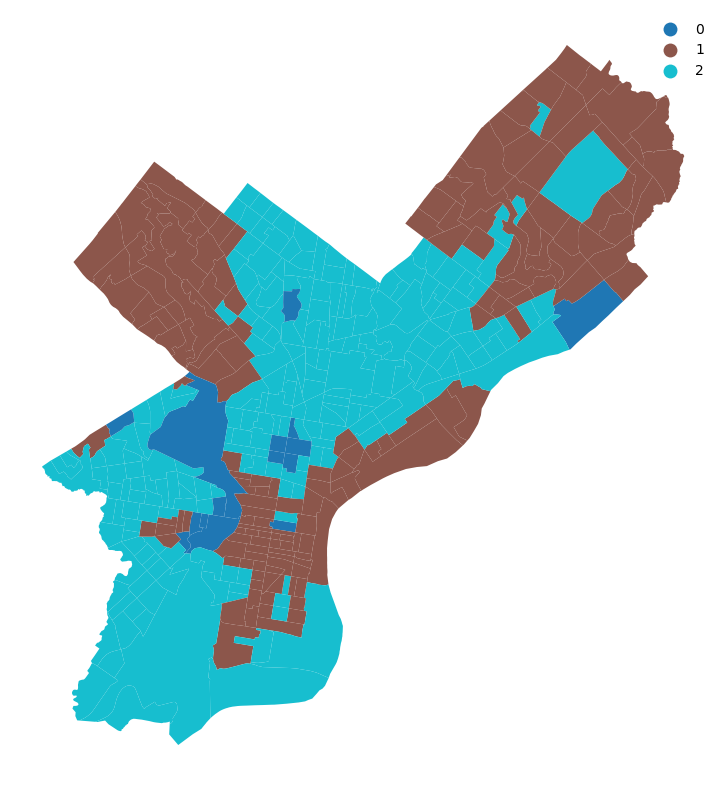

In [26]:
#| fig-cap: 'KMeans Clustering by Labels'
#| code-fold : true
#| code-summary: "Code for Visualization"


# Step 1: Convert the DataFrame to a GeoDataFrame if not already one
geo_combined_data = gpd.GeoDataFrame(combined_data, geometry='geometry')

# Step 2: Ensure CRS is set and transform to EPSG:3857
if geo_combined_data.crs is None:
    geo_combined_data.set_crs("EPSG:4326", inplace=True)  # Assuming original CRS is EPSG:4326
geo_combined_data = geo_combined_data.to_crs("EPSG:3857")

# Step 3: Plot the clusters without x and y information
fig, ax = plt.subplots(figsize=(10, 8))
geo_combined_data.plot(column='label', categorical=True, legend=True, cmap='tab10', ax=ax, legend_kwds={'frameon': False})

# Step 4: Remove axis labels, ticks, and bounding box
ax.set_axis_off()  # Turn off the entire axis
plt.tight_layout()

# Step 5: Show the plot
plt.show()

Using K-means clustering, we segmented the data into three clusters based on socioeconomic status. The clusters were visualized on a map of Philadelphia by census tracts to display spatial distribution patterns:

- **Cluster 0 (Blue):** Concentrated in central Philadelphia and a few scattered tracts throughout the city. 

- **Cluster 1 (Brown):** Primarily located in northern, eastern, and northwestern Philadelphia.


- **Cluster 2 (Teal):** Dominates large areas in Philadelphia's southern, western, and northeastern parts.

    

## 3.3. Export Clusters by Label

This code ensures that the GeoDataFrame has only one active geometry column and exports each cluster as a separate GeoJSON file:

In [17]:
# Handle Geometry Columns
geo_combined_data = geo_combined_data[[col for col in geo_combined_data.columns if not col.startswith('geometry_')]]
geo_combined_data = geo_combined_data.set_geometry('geometry')

In [18]:
# Step 1: Define the base output directory
base_path = "data/"
output_dir = os.path.join(base_path, "output_by_label")
os.makedirs(output_dir, exist_ok=True)

# Step 2: Ensure only one geometry column
# Drop other geometry columns if they exist
geometry_columns = [col for col in geo_combined_data.columns if geo_combined_data[col].dtype.name == 'geometry']
if len(geometry_columns) > 1:
    print("Multiple geometry columns detected. Dropping all but the active one.")
    geo_combined_data = geo_combined_data.drop(columns=[col for col in geometry_columns if col != 'geometry'])

# Ensure the 'geometry' column is set as the active geometry
geo_combined_data = geo_combined_data.set_geometry('geometry')

# Step 3: Iterate over unique labels and save each subset
for label in geo_combined_data['label'].unique():
    label_data = geo_combined_data[geo_combined_data['label'] == label]
    file_path = os.path.join(output_dir, f"label_{label}.geojson")  # Output file path
    label_data.to_file(file_path, driver="GeoJSON")  # Save as GeoJSON
    print(f"Saved data for label {label} to {file_path}")

Saved data for label 0 to data/output_by_label\label_0.geojson
Saved data for label 1 to data/output_by_label\label_1.geojson
Saved data for label 2 to data/output_by_label\label_2.geojson


## 3.4. Clustering Analysis

Next, we created box plots to analyze the distribution of socioeconomic variables across clusters, providing insights into their unique characteristics. Each group had the following characteristics:

This code creates box plots to analyze the distribution of selected socio-economic variables across different clusters. 

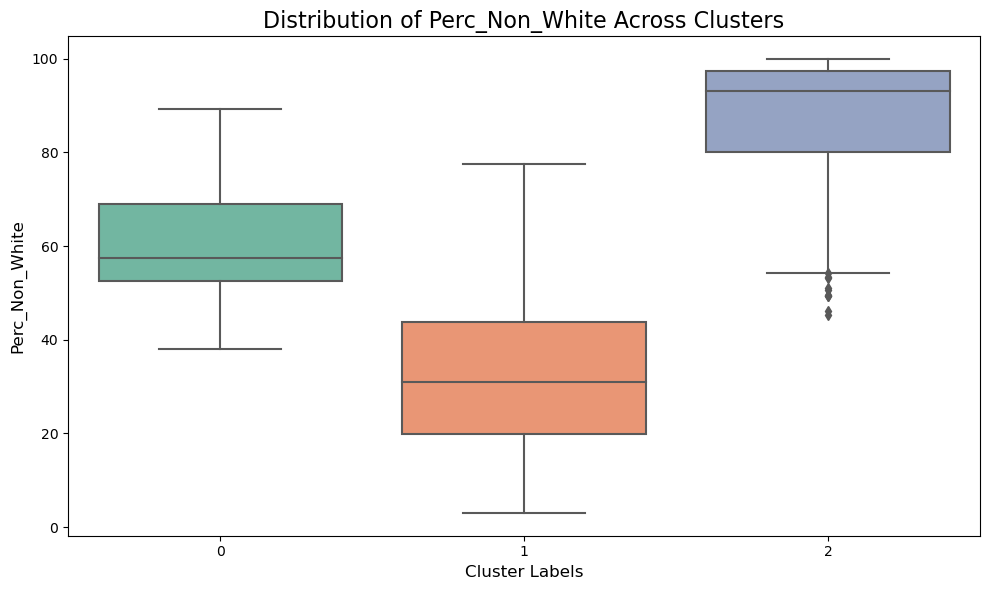

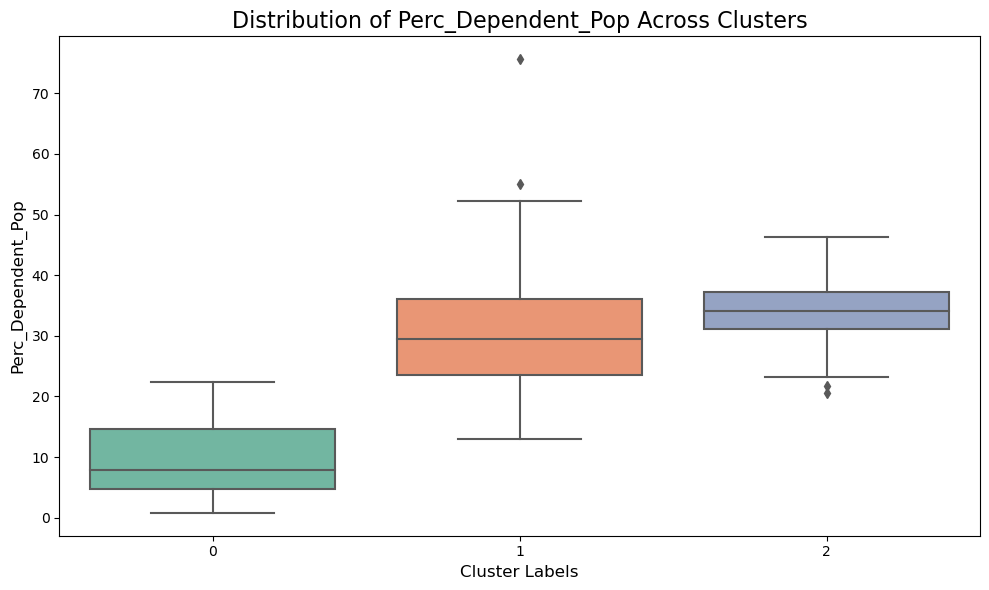

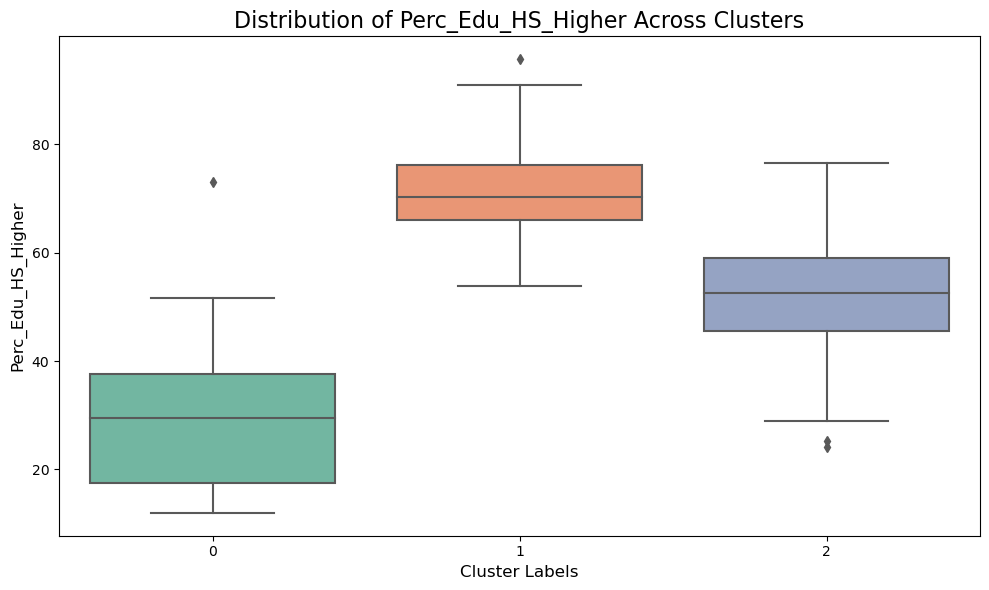

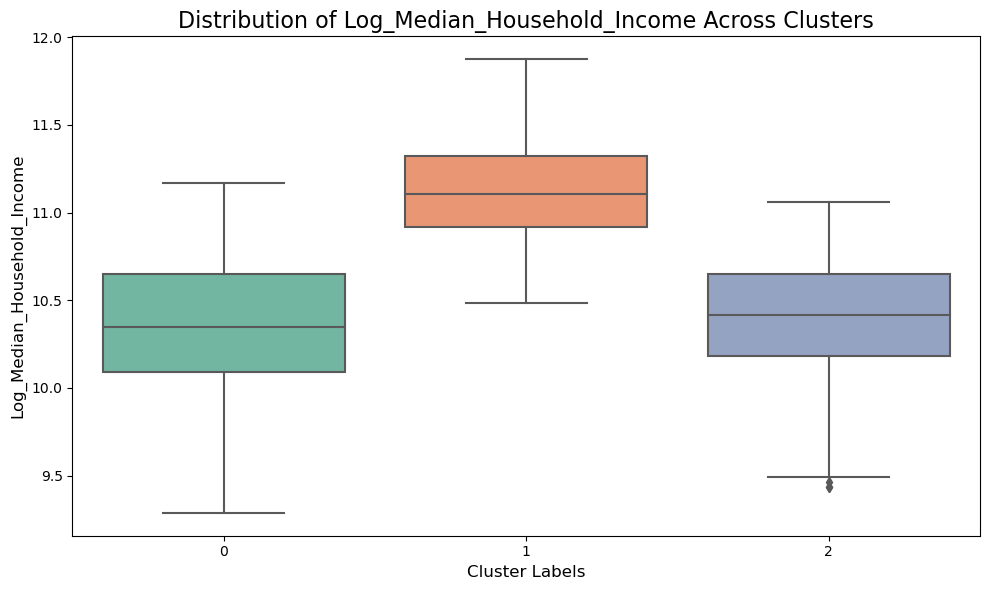

In [27]:
#| layout-ncol: 2

# List of columns to analyze
columns_to_plot = ['Perc_Non_White', 'Perc_Dependent_Pop', 'Perc_Edu_HS_Higher', 'Log_Median_Household_Income']

# Create a box plot for each column
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='label', y=column, data=geo_combined_data, palette="Set2")
    plt.title(f"Distribution of {column} Across Clusters", fontsize=16)
    plt.xlabel("Cluster Labels", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.tight_layout()
    plt.show()

### Box Plot Explanation

- **Group 0 (Socioeconomically vulnerable)**: Low median household income, low percentage of individuals with high school or higher education, low dependent population percentage, and high percentage of non-white residents.

- **Group 1 (Less socioeconomically vulnerable)**: High median household income, high education attainment, medium dependent population percentage, and low percentage of non-white residents

- **Group 2 (Excluded from further analysis)**: This group had a high percentage of non-white and dependent population, low median household income, and lower education levels. Some significant outliers were present in this group, suggesting the need to exclude them from further analysis and limiting the reliability of the analysis for this cluster.

---

From the box plots:

- **Group 0** represents a socio-economically vulnerable population, with lower median household income, lower education levels, and a higher percentage of non-white population.

- While **Group 1** has a higher dependent population percentage, **Group 0** demonstrates more socio-economic vulnerabilites overall.


## 3.5. Tree Canopy Effect on Public Health

This analysis examines the relationship between tree canopy coverage and public health outcomes within clusters of similar socio-economic status. 

- **Key Variables**: Includes tree canopy percentage, lead exposure, asthma prevalence, cancer prevalence, and heat vulnerability index.

- **Methodology**: For each cluster, correlations between these variables are computed and visualized using heatmaps.

- **Objective**: To identify how tree canopy affects public health indicators across different socio-economic groups.


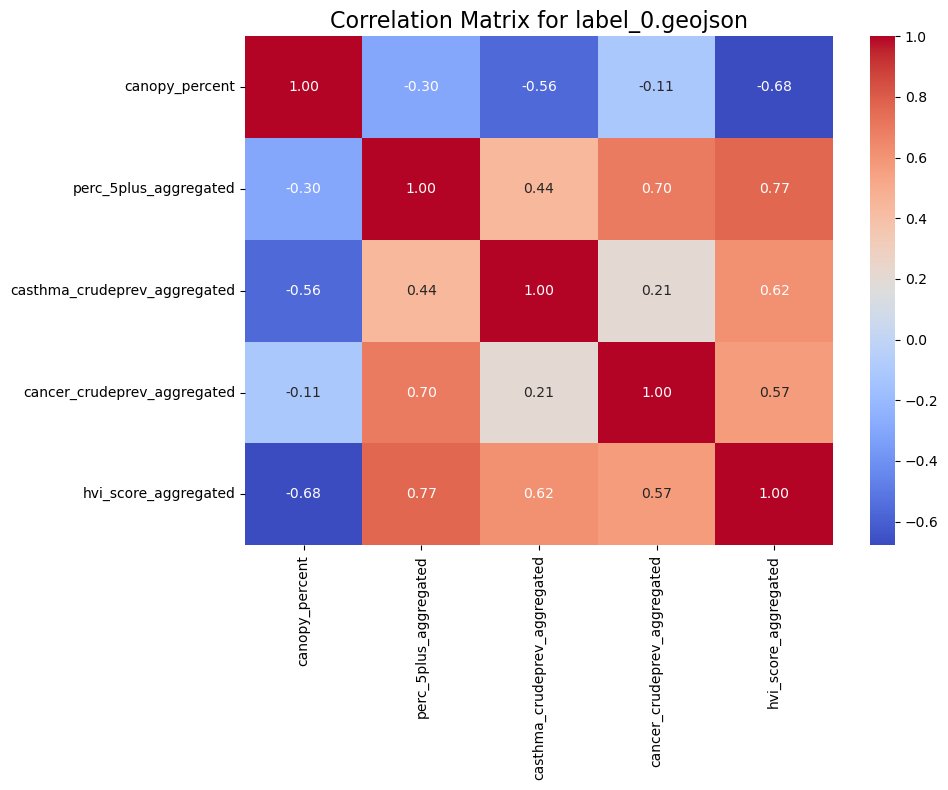

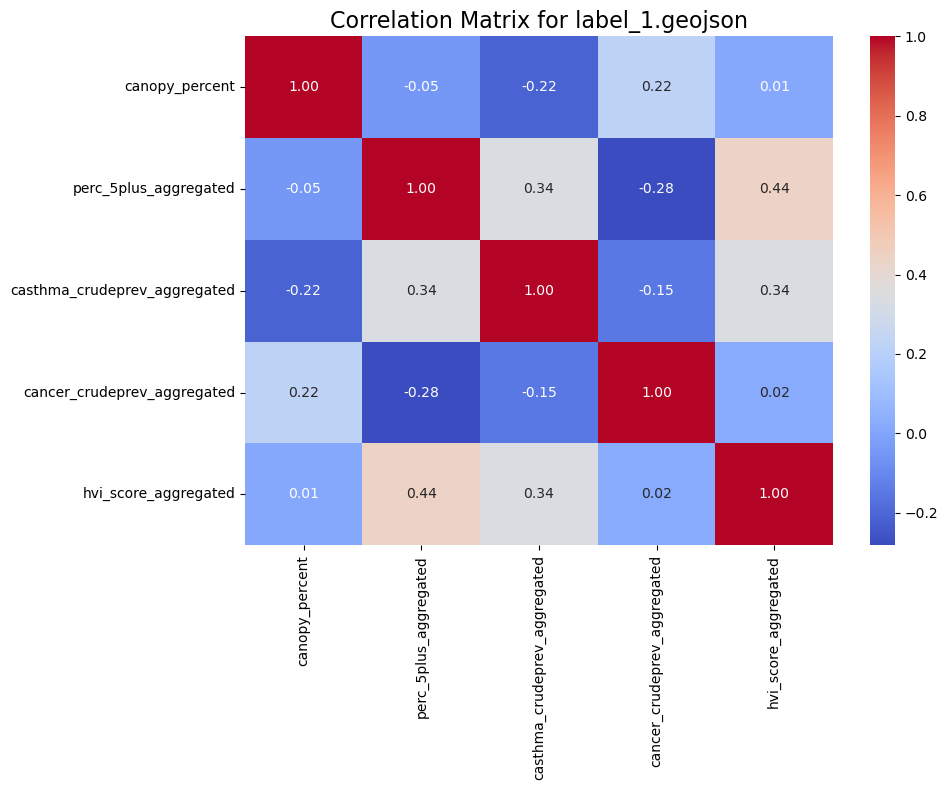

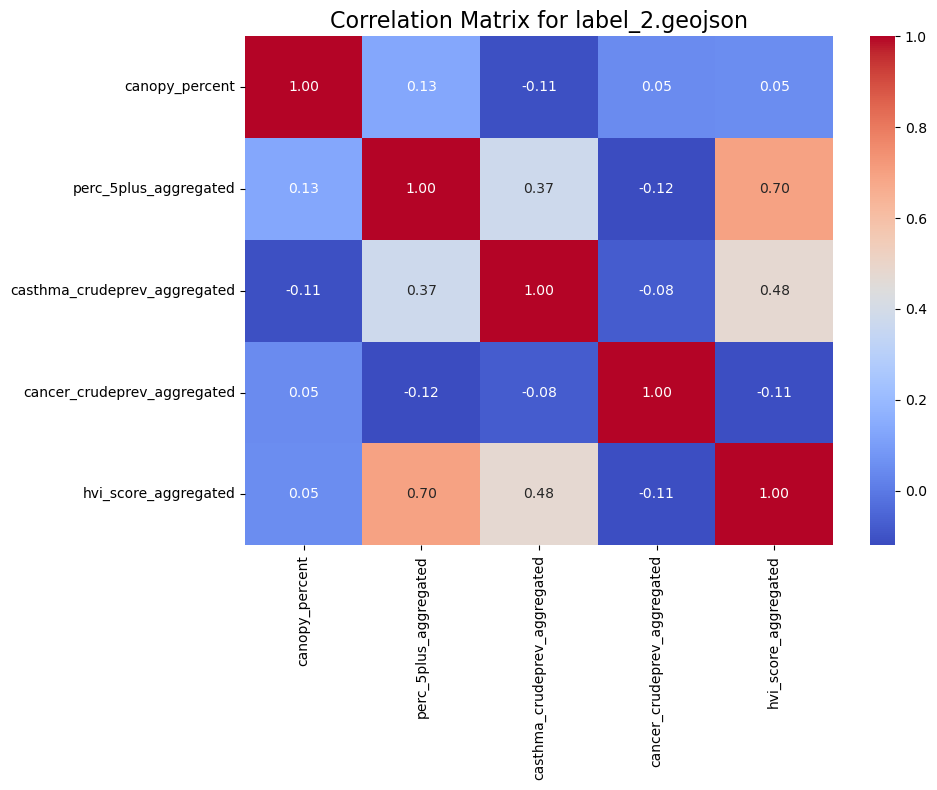

In [29]:
# Directory containing the GeoJSON files
input_dir = "data/output_by_label"

# Iterate through each GeoJSON file
for file_name in os.listdir(input_dir):
    if file_name.endswith(".geojson"):
        file_path = os.path.join(input_dir, file_name)
        
        # Load the GeoJSON file into a GeoDataFrame
        gdf = gpd.read_file(file_path)
        
        # Extract the required columns
        required_columns = ['canopy_percent', 'perc_5plus_aggregated', 
                            'casthma_crudeprev_aggregated', 'cancer_crudeprev_aggregated', 
                            'hvi_score_aggregated']
        
        # Ensure columns exist in the GeoDataFrame
        missing_columns = [col for col in required_columns if col not in gdf.columns]
        if missing_columns:
            print(f"Skipping {file_name}: Missing columns {missing_columns}")
            continue
        
        # Compute the correlation matrix
        correlation_matrix = gdf[required_columns].corr()
        
        # Plot the correlation matrix as a heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
        plt.title(f"Correlation Matrix for {file_name}", fontsize=16)
        plt.tight_layout()
        
        # Display the heatmap
        plt.show()

# Summary

Our data exploration provided valuable insight into the relationships between socioeconomic factors and environmental health outcomes. Ultimately, using our analysis, we want to identify how tree canopy affects public health indicators across different socioeconomic groups. We analyzed the correlations between tree canopy and various health indicators within each cluster and found the following:

-  **Group 0 (Vulnerable Population)**:Tree canopy coverage negatively correlated with lead exposure, asthma rates, cancer rates, and heat vulnerability index. This implies that increased tree canopy in vulnerable areas could significantly improve public health outcomes. The City of Philadelphia should prioritize tree-planting initiatives in these neighborhoods.

-  **Group 1 (Less Vulnerable Population)**: There are negative correlations between tree canopy and lead exposure/asthma rates indicate continued benefits. Weak positive correlations with cancer prevalence and heat vulnerability suggest more complex relationships in these areas. This shows that while beneficial, tree canopy may be less critical in improving health outcomes than vulnerable areas.